# MQDT Calculations for Ytterbium

The pairinteraction software supports atomic species with two valence electrons such as Yb171 and Yb174, using multi-channel quantum defect theory (MQDT). In the following, we reproduce findings of the publication [M. Peper et al., *Spectroscopy and modeling of 171Yb Rydberg states for high-fidelity two-qubit gates"*, 2024](https://arxiv.org/abs/2406.01482). In this publication, the authors carefully benchmarked their results against experimental data.

## Zeeman Map for Yb174

We calculate the Zeeman map for Yb174 that is shown in Fig. 13 of the publication. The Zeeman map takes into account diamagnetism.

Note: you may need to restart the kernel to use updated packages.


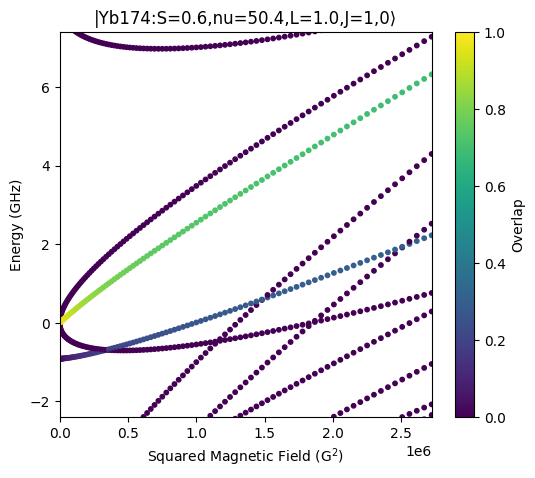

In [1]:
%pip install -q matplotlib numpy pairinteraction

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

# Get the state of interest
ket = pi.KetAtom("Yb174_mqdt", nu=50, s=1, l=1, j=1, m=0)
energy_in_ghz = ket.get_energy(unit="GHz")

# Construct a basis around the state
basis = pi.BasisAtom("Yb174_mqdt", nu=(ket.nu - 3, ket.nu + 3), j=(0, 2))

# Construct and diagonalize systems for different magnetic fields
list_bfield_in_gauss = np.linspace(0, 1650, 100)
list_system = [
    pi.SystemAtom(basis).set_magnetic_field([0, 0, b], unit="G").set_diamagnetism_enabled(True)
    for b in list_bfield_in_gauss
]
pi.diagonalize(list_system, diagonalizer="lapacke_evd", float_type="float32")

# Get eigenenergies and overlaps
list_eigenenergies = np.array([system.get_eigenenergies(unit="GHz") for system in list_system])
list_overlap = np.array([system.get_eigenbasis().get_overlaps(ket) for system in list_system])

# Plot the Zeeman map
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(ket.get_label("ket"))
scat = ax.scatter(
    np.repeat(list_bfield_in_gauss, list_eigenenergies.shape[1]) ** 2,
    list_eigenenergies - energy_in_ghz,
    c=list_overlap,
    s=10,
    vmin=0,
    vmax=1,
)
fig.colorbar(scat, label="Overlap")
ax.set_xlim(0, list_bfield_in_gauss[-1] ** 2)
ax.set_ylim(-2.4, 7.4)
ax.set_xlabel(r"Squared Magnetic Field (G$^2$)")
ax.set_ylabel("Energy (GHz)")
plt.show()

## Pair Potentials for Yb171

We calculate the pair potentials for Yb171 that are displayed in Fig. 7a of the publication. The pair potentials are calculated for a magnetic field pointing along the z-axis and the interatomic axis pointing along the x-axis. Because this arrangement breaks rotational symmetry, the total magnetic quantum number is not conserved and two-atom Hilbert space is rather large. To keep the execution time down, we only calculate the pair potentials for a few interatomic distances.

Note: you may need to restart the kernel to use updated packages.
Single atom basis size: 260
Pair basis size: 3392


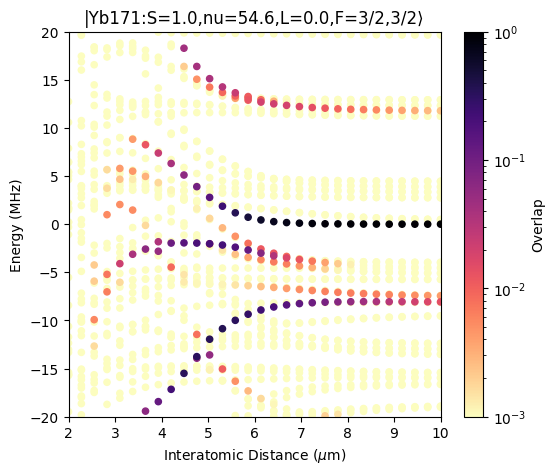

In [2]:
%pip install -q matplotlib numpy pairinteraction

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

# Get the state of interest
ket = pi.KetAtom("Yb171_mqdt", nu=54.56, l=0, f=3 / 2, m=3 / 2)

# Construct a basis around the state
basis = pi.BasisAtom("Yb171_mqdt", nu=(ket.nu - 2, ket.nu + 2), f=(0.5, 2.5), l=(0, 2))
print(f"Single atom basis size: {basis.number_of_states}", flush=True)

# Construct and diagonalize a system for a single atom
system = (
    pi.SystemAtom(basis)
    .set_magnetic_field([0, 0, 5.03], unit="G")
    .set_diamagnetism_enabled(True)
    .diagonalize(diagonalizer="lapacke_evr", float_type="float32")
)
pair_energy_shifted = 2 * system.get_corresponding_energy(ket, unit="MHz")

# Construct a basis for a pair of atoms
basis_pair = pi.BasisPair(
    [system, system],
    energy=(pair_energy_shifted - 3.5e3, pair_energy_shifted + 3.5e3),
    energy_unit="MHz",
)
print(f"Pair basis size: {basis_pair.number_of_states}", flush=True)

# Construct and diagonalize systems for different interatomic distances
list_distances = np.linspace(2, 10, 30)
list_system = [
    pi.SystemPair(basis_pair).set_distance_vector([d, 0, 0], unit="um") for d in list_distances
]
pi.diagonalize(
    list_system,
    diagonalizer="lapacke_evr",
    float_type="float32",
    energy_range=(pair_energy_shifted - 20, pair_energy_shifted + 20),
    energy_range_unit="MHz",
    rtol=1e-6,
)

# Get eigenenergies and overlaps
list_eigenenergies = [system.get_eigenenergies(unit="MHz") for system in list_system]
list_overlap = [system.get_eigenbasis().get_overlaps([ket, ket]) for system in list_system]
list_distances = [d * np.ones_like(e) for d, e in zip(list_distances, list_eigenenergies)]

# Plot the pair potential
list_eigenenergies = np.hstack(list_eigenenergies)
list_overlap = np.hstack(list_overlap)
list_distances = np.hstack(list_distances)
sorter = np.argsort(list_overlap)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(ket.get_label("ket"))
scat = ax.scatter(
    list_distances[sorter],
    list_eigenenergies[sorter] - pair_energy_shifted,
    c=list_overlap[sorter],
    s=20,
    vmin=1e-3,
    vmax=1,
    norm="log",
    cmap="magma_r",
)
fig.colorbar(scat, label="Overlap")
ax.set_xlim(2, 10)
ax.set_ylim(-20, 20)
ax.set_xlabel(r"Interatomic Distance ($\mu$m)")
ax.set_ylabel("Energy (MHz)")
plt.show()